In [1]:
#setting-up libraries
import pandas as pd
import numpy as np
import sys
import math as math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [2]:
#making dataframe from GMS.xlsx
#required 'xlrd' library
dfgms = pd.read_excel('Data/GMS.xlsx', usecols=1, names=['date', 'gms'])
#usecols=1 - limiting only column A and B (0 and 1)
#names=... giving to columns names

#Drop last line, which have incomplete months calculations
dfgms.drop(dfgms.tail(1).index,inplace=True)

#convert date column to date format
dfgms.date=pd.to_datetime(dfgms.date, format='%Y%m', errors='ignore')

#set date column as an index in data frame
dfgms.set_index('date', inplace=True)

dfgms.head()

,gms
date,
2014-01-01,2736602801
2014-02-01,2716484076
2014-03-01,3948996400
2014-04-01,2891937535
2014-05-01,2456764829


In [3]:
#making dataframe from Devcost.xlsx
dfdev = pd.read_excel('data/Devcost.xlsx', names=['date', 'type', 'cost'])
#names=... giving to columns names

#filling NaN cells
dfdev = dfdev.fillna(method='ffill')

#to be able to operate with columns convert them float==>int
dfdev.date=dfdev.date.apply(np.int64)

#convert date column to date format
dfdev.date=pd.to_datetime(dfdev.date, format='%Y%m', errors='ignore')

#pivoting dataframe and setting date as an index
pivotdev=dfdev.pivot(index='date', columns='type', values='cost')

#Drop last 5 lines, which have incomplete months calculations
pivotdev.drop(pivotdev.tail(5).index,inplace=True)

#Drop unusing columns
pivotdev.drop(['Booked Cost', 'Budget Cost', 'Current Kebin Cost', 'Latest Forecast Cost'], axis=1, inplace=True)

#to be able to operate with columns convert them float==>int
pivotdev['Actual Cost']=pivotdev['Actual Cost'].apply(np.int64)

pivotdev.head()

type,Actual Cost
date,
2014-01-01,71882325
2014-02-01,74029202
2014-03-01,74595732
2014-04-01,77198683
2014-05-01,74977459


In [4]:
dffinal=pd.merge(dfgms, pivotdev, left_index=True, right_index=True)
print(dffinal)

                   gms  Actual Cost
date                               
2014-01-01  2736602801     71882325
2014-02-01  2716484076     74029202
2014-03-01  3948996400     74595732
2014-04-01  2891937535     77198683
2014-05-01  2456764829     74977459
2014-06-01  3577153984     74961792
2014-07-01  3146373651     84020207
2014-08-01  2958189959     76950033
2014-09-01  3030965127     80468083
2014-10-01  2934359493     83165918
2014-11-01  3380975878     80671842
2014-12-01  4009744501     87952522
2015-01-01  3126407399     81693087
2015-02-01  3019304427     78989912
2015-03-01  3965565108     80589420
2015-04-01  2853364264     80853419
2015-05-01  2976066279     77706942
2015-06-01  2976371848     81921810
2015-07-01  2921007306     78309681
2015-08-01  3060592946     81037462
2015-09-01  3322417267     81523567
2015-10-01  3154240965     82473540
2015-11-01  3658018050     86754973
2015-12-01  4652916875     86228323
2016-01-01  3405417428     81113317
2016-02-01  3214434514     8

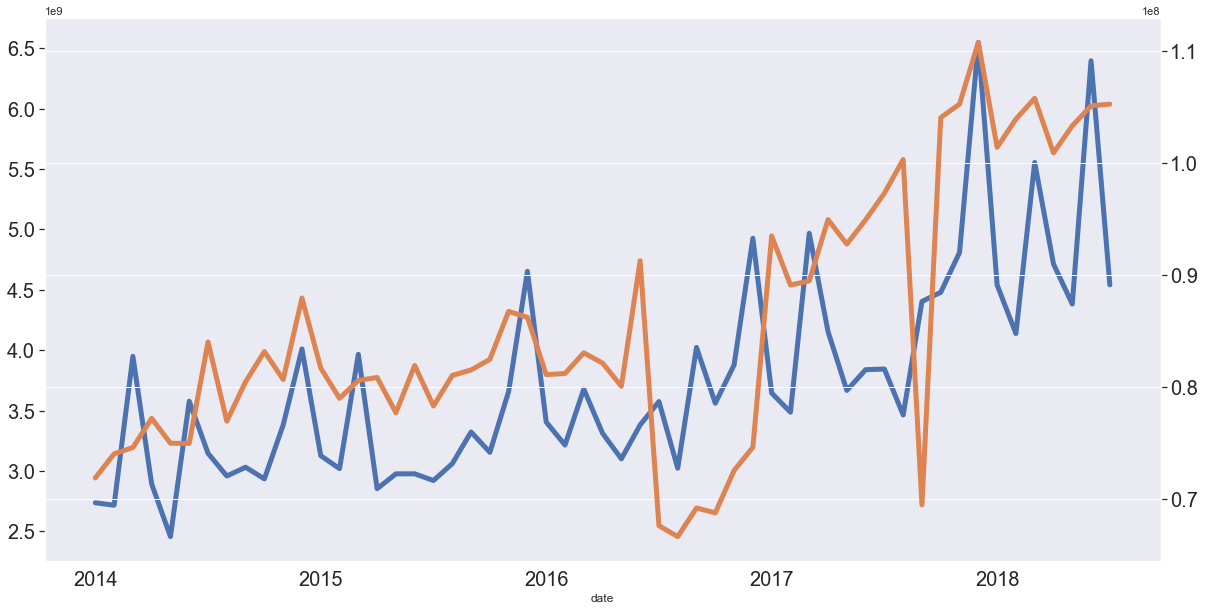

In [5]:
dffinal.gms.plot(figsize=(20,10), linewidth=5, fontsize=20)
dffinal['Actual Cost'].plot(secondary_y=True, linewidth=5, fontsize=20)

In [6]:
#find Parsons coefficient of correlation
dffinal.corr()

,gms,Actual Cost
gms,1.000000,0.640336
Actual Cost,0.640336,1.000000


In [11]:
#trendlines for GMS and Actual Cost based on half-dataset
half_df = dffinal[0:28]

z_gms = np.polyfit([i for i in range(half_df.shape[0])], half_df['gms'], 1)
z_cost = np.polyfit([i for i in range(half_df.shape[0])], half_df['Actual Cost'], 1)

slope_gms = z_gms[0]
intercept_gms = z_gms[1]
slope_cost = z_cost[0]
intercept_cost = z_cost[1]

print("Trendline equation for GMS half dataset: y=%.6fx+(%.6f)"%(z_gms[0],z_gms[1]))
print("Trendline equation for Actual Cost half dataset: y=%.6fx+(%.6f)"%(z_cost[0],z_cost[1]))

Trendline equation for GMS half dataset: y=20182320.808429x+(2980559349.371920)
Trendline equation for Actual Cost half dataset: y=302841.251505x+(76142828.211823)


In [14]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

hesf_df = dffinal.copy()
total_months = 60
alpha = 0.2
beta = 0.2
initial_level = intercept_gms
initial_trend = slope_gms

hesf_df['one_step_ahead_forecast'] = intercept_gms + slope_gms
hesf_df['forecast_error'] = hesf_df['gms'] - hesf_df['one_step_ahead_forecast']
hesf_df['level'] = intercept_gms + slope_gms + alpha * hesf_df['forecast_error']
hesf_df['trend'] = slope_gms + alpha * beta * hesf_df['forecast_error']

hesf1_df = hesf_df[['gms', 'level','trend','one_step_ahead_forecast','forecast_error']]

new_df = pd.DataFrame(data=[[0,0,0,0,0],
                       [0,0,0,0,0],
                       [0,0,0,0,0],
                       [0,0,0,0,0],
                       [0,0,0,0,0]], index=["2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01"],
                      columns=['gms','level','trend','one_step_ahead_forecast','forecast_error'])

hesf1_df = hesf1_df.append(new_df,ignore_index=False)
hesf1_df.index = pd.to_datetime(hesf1_df.index)

#Applying double exponential smoothing and forecasting orders
#for index, row in hesf1_df.iterrows():
#    if index <= '2018-08-01':
#        hesf1_df.loc[index,'one_step_ahead_forecast'] = hesf_df.loc[index-1,'level'] + hesf_df.loc[index-1,'trend']
#        hesf_df.loc[index,'forecast_error'] = hesf_df.loc[index, 'gms'] - hesf_df.loc[index,'one_step_ahead_forecast']
#        hesf_df.loc[index,'level'] = hesf_df.loc[index-1,'level'] + hesf_df.loc[index-1,'trend'] + alpha * hesf_df.loc[index,'forecast_error']
#        hesf_df.loc[index,'trend'] = hesf_df.loc[index-1,'trend'] + alpha * gamma * hesf_df.loc[index,'forecast_error']
#        last_known_month = hesf_df.loc[index,'month_number']
#        last_known_level = hesf_df.loc[index,'level']
#        last_known_trend = hesf_df.loc[index,'trend']
#    elif index > 55:
#        hesf_df.loc[index,'gms'] = last_known_level + (hesf_df.loc[index,'month_number'] - last_known_month ) * last_known_trend

hesf1_df

,gms,level,trend,one_step_ahead_forecast,forecast_error
2014-01-01,2736602801,2947913896.34,9616766.04,3000741670.18,-264138869.18
2014-02-01,2716484076,2943890151.34,8812017.04,3000741670.18,-284257594.18
2014-03-01,3948996400,3190392616.14,58112510.00,3000741670.18,948254729.82
2014-04-01,2891937535,2978980843.14,15830155.40,3000741670.18,-108804135.18
2014-05-01,2456764829,2891946301.94,-1576752.84,3000741670.18,-543976841.18
2014-06-01,3577153984,3116024132.94,43238813.36,3000741670.18,576412313.82
2014-07-01,3146373651,3029868066.34,26007600.04,3000741670.18,145631980.82
2014-08-01,2958189959,2992231327.94,18480252.36,3000741670.18,-42551711.18
2014-09-01,3030965127,3006786361.54,21391259.08,3000741670.18,30223456.82
2014-10-01,2934359493,2987465234.74,17527033.72,3000741670.18,-66382177.18
